In [1]:
import glob 
from math import isclose 
import os 
import pandas as pd
from pandas import ExcelWriter
import requests
import scipy.io
import scipy.signal
import numpy
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
### added numpy & matplotlibs

In [2]:
################################
### OVERALL Wrapper Function ###
################################

def get_all_data(path_to_raw_data_folder):
    '''Gets all raw data from the specified folder (path_to_raw_data_folder), and then 
    1. separates it into raw cycles and puts them in a folder (data/Separated_Cycles/)
    2. cleans those separated cycles and puts them in a folder (data/Clean_Separated_Cycles/)
    3. recombines the cleaned, separated cycles and saves those data sets in a folder (data/Clean_Whole_Sets/)
    These folders do not have to have existed previously. '''
    if not os.path.exists('data/'):
        os.makedirs('data/')
    if not os.path.exists('data/Separated_Cycles/'):
        os.makedirs('data/Separated_Cycles/')
    if not os.path.exists('data/Clean_Separated_Cycles/'):
        os.makedirs('data/Clean_Separated_Cycles/')
    if not os.path.exists('data/Clean_Whole_Sets/'):
        os.makedirs('data/Clean_Whole_Sets/')
    load_sep_cycles(path_to_raw_data_folder, 'data/Separated_Cycles/')
    get_clean_cycles('data/Separated_Cycles/', 'data/Clean_Separated_Cycles/')
    get_clean_sets('data/Clean_Separated_Cycles/', 'data/Clean_Whole_Sets/')
    return 

##### Notes: 'get_all_data' doesn't work if I forget to add the last slash in the path name

In [3]:
############################
### Sub - Wrapper Functions
############################

def load_sep_cycles(getdata_filepath, savedata_filepath):
    """Get data from a specified filepath, separates out data into cycles and saves those cycles as .xlsx files in specified filepath (must be an existing folder)"""
    dfdict = get_data(getdata_filepath)
    for key in dfdict:
        all_cycles_df = dfdict[key]
        cycle_dict = sep_cycles(all_cycles_df)
        battname = key 
        save_sep_cycles_xlsx(cycle_dict, battname, savedata_filepath) 
    print('All data separated into cycles and saved in folder "data/Separated_Cycles". ')
    return 

##### ^depends on get_data, sep_cycles, and save_sep_cycles_xlsx

In [4]:
############################
# Component Functions
############################

def get_data(filepath): 
    """Imports all data in given path"""
    assert type(filepath) == str, 'Input must be a string'
    rootdir = filepath
    file_list = [f for f in glob.glob(os.path.join(rootdir,'*.xlsx'))] #iterate through dir to get excel files 
    
    d = {} #initiate dict for data storage
    count = 0
    for file in file_list:
        count += 1
        name = os.path.split(file)[1].split('.')[0]
        data = pd.read_excel(file,1)
        new_set = {name : data}
        d.update(new_set)
       # print("adding file " + str(count) + ' ' + str(name))
    return d
### ADD UNIT TEST:There are 23 files in the CS2 directory, so we should have 23 entries in the dictionary - add unit test for this, super EASY check 



In [5]:
#separate out dataframes into cycles
def sep_cycles(dataframe):
    """This function separates out the cycles in the battery dataframe by grouping by the 'Cycle_Index' column, and putting them in a dictionary. """
    assert type(dataframe) == pd.DataFrame, 'Input must be a dataframe' 
    gb = dataframe.groupby(by = ['Cycle_Index'])
    cycle_dict = dict(iter(gb))
    return cycle_dict

In [6]:
def save_sep_cycles_xlsx(cycle_dict, battname, path_to_folder):
    '''This saves the separated out cycles into different excel files, beginning with the battery name. Battname and path to folder must be strings.'''
    for i in range(1, len(cycle_dict)):
         cycle_dict[i]['Battery_Label'] = battname
    for i in range(1,len(cycle_dict)):
        writer = ExcelWriter(path_to_folder + battname + '-'+'Cycle' + str(i) + '.xlsx') 
        cycle_dict[i].to_excel(writer)
        writer.save()
    return

# Fun bits here

In [72]:
get_all_data('data/K2_039/')

All data separated into cycles and saved in folder "data/Separated_Cycles". 
All cycles cleaned and saved in folder "data/Clean_Separated_Cycles".
All clean cycles recombined and saved in folder "data/Clean_Whole_Sets".


In [80]:
asdf = pd.read_excel('data/Clean_Separated_Cycles/1_28_14_1C_Cycle-Cycle8Clean.xlsx')


In [81]:
asdf.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,ACI_Phase_Angle(Deg),Battery_Label,dV,Discharge_dQ,Charge_dQ,Discharge_dQ/dV,Charge_dQ/dV,dv_close_to_zero,dQ/dV,Smoothed_dQ/dV


In [71]:
abs(asdf['dQ/dV']).describe()

count     0
unique    0
Name: dQ/dV, dtype: int64

In [78]:
fig1 = plt.figure(figsize = (10,10), facecolor = 'w', edgecolor = 'k')
#myplot = plt.plot(asdf['Data_Point'],asdf['dQ/dV'])
myplot = plt.plot(asdf['Voltage(V)'],asdf['dQ/dV'])
myplot2 = plt.plot(asdf['Voltage(V)'],asdf['Smoothed_dQ/dV'])

KeyError: 'dQ/dV'

<Figure size 720x720 with 0 Axes>

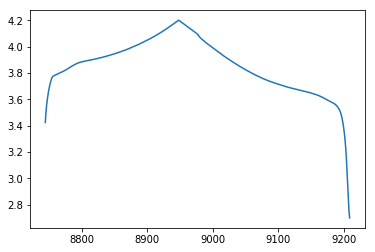

In [52]:
myplot = plt.plot(asdf['Data_Point'],asdf['Voltage(V)'])

## this guy  down here  depends on clean_calc_sep_smooth 

In [8]:
def get_clean_cycles(import_filepath, save_filepath): 
    """Imports all separated out cycles in given path and cleans them and saves them in the specified filepath"""
    rootdir = import_filepath
    file_list = [f for f in glob.glob(os.path.join(rootdir,'*.xlsx'))] #iterate through dir to get excel files 
    d = {} #initiate dict for data storage
    count = 0
    for file in file_list:
        count += 1
        name = os.path.split(file)[1].split('.')[0]
        data = pd.read_excel(file)
        charge, discharge = clean_calc_sep_smooth(data, 15, 3)
        clean_data = charge.append(discharge)
        clean_cycle = {name : clean_data}
        d.update(clean_cycle)
       # print("adding file to dictionary" + str(count) + ' ' + str(name))
    for key in d:
        clean_cycle_df = d[key]
        cyclename = key 
        writer = ExcelWriter(save_filepath + cyclename + 'Clean'+ '.xlsx')
        clean_cycle_df.to_excel(writer)
        writer.save() 
    print('All cycles cleaned and saved in folder "data/Clean_Separated_Cycles".')
    return 

In [95]:
get_clean_cycles('data/Separated_Cycles/','data/Clean_Separated_Cycles/')

All cycles cleaned and saved in folder "data/Clean_Separated_Cycles".


In [90]:
def clean_calc_sep_smooth(dataframe, windowlength, polyorder):
    """Takes one cycle dataframe, calculates dq/dv, cleans the data, separates out charge and discharge, and applies sav-golay filter. Returns two dataframes, one charge and one discharge.
    Windowlength and polyorder are for the sav-golay filter."""
    df1 = calc_dv_dqdv(dataframe)
    df2 = drop_0_dv(df1) 
    
    
    
    charge, discharge = sep_char_dis(df2)
    if len(discharge) > windowlength:
        smooth_discharge = my_savgolay(discharge, windowlength, polyorder)
    else:
        discharge['Smoothed_dQ/dV'] = discharge['dQ/dV']
        smooth_discharge = discharge
    if len(charge) > windowlength: 
        smooth_charge = my_savgolay(charge, windowlength, polyorder)
    else:
        charge['Smoothed_dQ/dV'] = charge['dQ/dV']
        smooth_charge = charge   
    return smooth_charge, smooth_discharge

##### depends on calc_dv_dqdv and drop_0_dv and sep_char_dis and my_savgolay

In [10]:
def calc_dv_dqdv(cycle_df):
    """This function calculates the dv and the dq/dv for a dataframe."""
    cycle_df = cycle_df.reset_index(drop = True)
    cycle_df['dV'] = None 
    cycle_df['Discharge_dQ'] = None
    cycle_df['Charge_dQ'] = None 
    cycle_df['Discharge_dQ/dV'] = None
    cycle_df['Charge_dQ/dV'] = None  
    for i in range(1,len(cycle_df)): 
        cycle_df.loc[i, ('dV')] = cycle_df.loc[i, ('Voltage(V)')] - cycle_df.loc[i-1, ('Voltage(V)')]  
        cycle_df.loc[i, ('Discharge_dQ')] = cycle_df.loc[i, ('Discharge_Capacity(Ah)')] - cycle_df.loc[i-1, ('Discharge_Capacity(Ah)')]
        cycle_df.loc[i, ('Charge_dQ')] = cycle_df.loc[i, ('Charge_Capacity(Ah)')] - cycle_df.loc[i-1, ('Charge_Capacity(Ah)')]
    #calculate dq/dv based off of discharge capacity - might change this later so user can choose to use charge or discharge cap. 
    cycle_df['Discharge_dQ/dV'] = cycle_df['Discharge_dQ']/cycle_df['dV']
    cycle_df['Charge_dQ/dV'] = cycle_df['Charge_dQ']/cycle_df['dV']
    return cycle_df

### this looks good as hell up there ^^

In [94]:
def drop_0_dv(cycle_df_dv): 
    '''Drop rows where dv=0 (or about 0) in a dataframe that has already had dv calculated. Then recalculate dv and calculate dq/dv'''
    #this will clean up the data points around V = 4.2V (since they are holding it at 4.2V for a while).
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
   
    ### if the current is close to 0, ignore that row
    cycle_df_dv['dv_close_to_zero'] = None
    for i in range(1, len(cycle_df_dv)):
    	if isclose(cycle_df_dv.loc[i, ('Current(A)')], 0, abs_tol = 10**-3):
    		cycle_df_dv = cycle_df_dv.drop(index = i) 

    cycle_df_dv = cycle_df_dv.reset_index(drop = True)		
    
    ### if dV is too close to 0, ignore that row too
    for i in range(1, len(cycle_df_dv)):
        if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3):
            cycle_df_dv = cycle_df_dv.drop(index = i) 
            #cycle_df_dv.loc[i,('dv_close_to_zero')] = False
        else:
            pass#cycle_df_dv.loc[i,('dv_close_to_zero')]= True   
    
    
   # while (False in cycle_df_dv['dv_close_to_zero'].values or cycle_df_dv['dV'].max() > 0.7 or cycle_df_dv['dV'].min() < -0.7): 
   #     
   #     cycle_df_dv = cycle_df_dv.reset_index(drop = True)
   #     
    #    for i in range(1, len(cycle_df_dv)):
     #       if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3.5): 
      #          cycle_df_dv = cycle_df_dv.drop(index = i)
       #         
        #cycle_df_dv = cycle_df_dv.reset_index(drop = True)
        #
       # for i in range(1, len(cycle_df_dv)):
       #     if (cycle_df_dv.loc[i,('dV')] > 0.7 or cycle_df_dv.loc[i,('dV')] < -0.7):
        #        cycle_df_dv = cycle_df_dv.drop(index = i)       
         #       
       # cycle_df_dv = cycle_df_dv.reset_index(drop = True)
       # 
       # for i in range(1, len(cycle_df_dv)): 
       #     cycle_df_dv.loc[i, ('dV')] = cycle_df_dv.loc[i, ('Voltage(V)')] - cycle_df_dv.loc[i-1, ('Voltage(V)')] 
       #     if isclose(cycle_df_dv.loc[i, ('dV')], 0, abs_tol = 10**-3):
       #         cycle_df_dv.loc[i,('dv_close_to_zero')] = False
       #     else:
       #         cycle_df_dv.loc[i,('dv_close_to_zero')]= True
       #         
       # cycle_df_dv = cycle_df_dv.reset_index(drop = True)            
    
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
   
    #recalculating dv and dq's after dropping rows
    for i in range(1, len(cycle_df_dv)): 
        cycle_df_dv.loc[i, ('dV')] = cycle_df_dv.loc[i, ('Voltage(V)')] - cycle_df_dv.loc[i-1, ('Voltage(V)')]
        cycle_df_dv.loc[i, ('Discharge_dQ')] = cycle_df_dv.loc[i, ('Discharge_Capacity(Ah)')] - cycle_df_dv.loc[i-1, ('Discharge_Capacity(Ah)')]
        cycle_df_dv.loc[i, ('Charge_dQ')] = cycle_df_dv.loc[i, ('Charge_Capacity(Ah)')] - cycle_df_dv.loc[i-1, ('Charge_Capacity(Ah)')]
    #recalculate dq/dv  
    cycle_df_dv['Discharge_dQ/dV'] = cycle_df_dv['Discharge_dQ']/cycle_df_dv['dV']
    cycle_df_dv['Charge_dQ/dV'] = cycle_df_dv['Charge_dQ']/cycle_df_dv['dV']
    cycle_df_dv = cycle_df_dv.dropna(subset=['Discharge_dQ/dV'])
    cycle_df_dv = cycle_df_dv.dropna(subset=['Charge_dQ/dV'])
    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
   # cycle_df_dv = cycle_df_dv[:-1]

    

    ###only new part here!!!
    
    ## Example:
    #import numpy
    #a = [1, 2, 1, 1, -3, -4, 7, 8, 9, 10, -2, 1, -3, 5, 6, 7, -10]
    #zero_crossings = numpy.where(numpy.diff(numpy.sign(a)))[0]
    ###Source: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
    
    
    # Delete the row where the sign of the current switches
    switch_cd_index = numpy.where(numpy.diff(numpy.sign(cycle_df_dv['Current(A)'])))
    for i in switch_cd_index:
        cycle_df_dv = cycle_df_dv.drop(cycle_df_dv.index[i+1])
   
    #### back to the old stuff

    cycle_df_dv = cycle_df_dv.reset_index(drop = True)
    return cycle_df_dv 

### ^ not sure if the new part I added does anything but it doesn't hurt

In [48]:
def sep_char_dis(df_dqdv):
    '''Takes a dataframe of one cycle with calculated dq/dv and separates into charge and discharge differential capacity curves'''
    charge = df_dqdv[df_dqdv['dV'] > 0]
    charge.is_copy = None
    charge['dQ/dV'] = charge['Charge_dQ/dV']
    charge = charge.reset_index(drop = True)
    
    ### nix anything where dq/dv is too small
    for i in range(1, len(charge)):
        if isclose(charge.loc[i, ['dQ/dV']], 0, abs_tol = 10**-3.5): 
            charge = charge.drop(index = i)
   # charge = charge.iloc[6:] <- not sure what this is all about, but the above new code should do the same thing but better!
    charge = charge.reset_index(drop = True)
    discharge = df_dqdv[df_dqdv['dV'] < 0] 
    discharge.is_copy = None 
    discharge['dQ/dV'] = discharge['Discharge_dQ/dV']
    discharge = discharge.reset_index(drop = True)
   # discharge = discharge.iloc[:-2]
  #  discharge = discharge.iloc[2:]
    #discharge = discharge.reset_index(drop = True)
    
    # same as above - nix anything where dq/dv is too close to 0
    #
    #
    for i in range(1, len(discharge)):
        if isclose(discharge.loc[i, ['dQ/dV']], 0, abs_tol = 10**-3.5): 
            discharge = discharge.drop(index = i)
                
    discharge = discharge.reset_index(drop = True)
    
    #
    #
    
    return charge, discharge

### ^ these two functions can probably be greatly simplified but aint nobody got time for that

In [13]:
def my_savgolay(dataframe, windowlength, polyorder):
    """Takes battery dataframe with a dQ/dV column and applies a sav_golay filter to it, returning the dataframe with a new column called Smoothed_dQ/dV"""
    unfilt = pd.concat([dataframe['dQ/dV']])
    unfiltar = unfilt.values
    #converts into an array 
    dataframe['Smoothed_dQ/dV'] = scipy.signal.savgol_filter(unfiltar, windowlength, polyorder)
    #had windowlength = 21 and polyorder = 3 before
    return dataframe

In [14]:
def get_clean_sets(import_filepath, save_filepath): 
    """Imports all clean cycles of data from import path and appends them into complete sets of battery data, saved into save_filepath"""
    rootdir = import_filepath
    file_list = [f for f in glob.glob(os.path.join(rootdir,'*.xlsx'))] #iterate through dir to get excel files 
    d = {} #initiate dict for data storage
    count = 0
    list_bats = [] 
    for file in file_list:
        count += 1
        name = os.path.split(file)[1].split('.')[0]
        batname = name.split('-')[0]
        if batname not in list_bats:
            list_bats.append(batname)
        else: None  
            
    set_dict = {}
    
    for i in range(len(list_bats)): 
        batID = list_bats[i] 
        setdf = pd.DataFrame()
        for file in file_list:
            name = os.path.split(file)[1].split('.')[0]
            batname = name.split('-')[0]
            if batname == batID:
                df = pd.read_excel(file)
                setdf = setdf.append(df, ignore_index=True)
            else:
                None 
        setdf = setdf.sort_values(['Data_Point'], ascending = True)
        newset = {batID : setdf}
        set_dict.update(newset) 
        
    for key, value in set_dict.items():
        writer = ExcelWriter(save_filepath + key + 'CleanSet'+'.xlsx')
        value.to_excel(writer)
        writer.save() 
                
    print('All clean cycles recombined and saved in folder "data/Clean_Whole_Sets".')
    return